In [47]:
# Needed for "cv2"
#!pip install opencv-python

In [53]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import vit_pytorch.cct as cct
from skimage.transform import resize
from torchvision import transforms

import support.download_data
import support.load_data
from scripts.model import *

path_to_data = "data"

## optional random seed
SEED = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Download the dataset

Download the dataset if it is not already present in the specified path.

In [ ]:
# support.download_data.download_and_extract_zip(path_to_data) # uncomment to download the dataset

# Load Dataset

Call the custom loader to load the images into a torch.DataLoader object. 

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize the image to 128x128 for lighter computation
    transforms.ToTensor(),
])

batch_size = 32

train_loader, test_loader, train_dataset, test_dataset = support.load_data.load_dataset(
    path_to_data, transform=transform, batch_size=batch_size)



# Define Model parameters

In [23]:
model_config = {
    "img_size" : (128, 128),
    "embedding_dim" : 32,
    "n_conv_layers" : 2,
    "kernel_size" : 7,
    "stride" : 2,
    "padding" : 3,
    "pooling_kernel_size" : 3,
    "pooling_stride" : 2,
    "pooling_padding" : 1,
    "num_layers" : 4,
    "num_heads" : 4,
    "mlp_ratio" : 3,
    "num_classes" : 2,
    "positional_embedding" : 'learnable'
}

In [11]:
model = cct.CCT(
    img_size = model_config['img_size'],
    embedding_dim = model_config['embedding_dim'],
    n_conv_layers = model_config['n_conv_layers'],
    kernel_size = model_config['kernel_size'],
    stride = model_config['stride'],
    padding = model_config['padding'],
    pooling_kernel_size = model_config['pooling_kernel_size'],
    pooling_stride = model_config['pooling_stride'],
    pooling_padding = model_config['pooling_padding'],
    num_layers = model_config['num_layers'],
    num_heads = model_config['num_heads'],
    mlp_ratio = model_config['mlp_ratio'],
    num_classes = model_config['num_classes'],
    positional_embedding  =model_config['positional_embedding']
)

# Define loss function and optimizer


In [12]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training step

In [13]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    model.to(device)

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# Testing step

In [14]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


# Training Loop

In [15]:
epochs = 20

results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device)
    
    print(f"Epoch: {epoch+1} | train_acc: {train_acc:.4f}")
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6880 | train_acc: 0.5744 | test_loss: 0.6545 | test_acc: 0.6872
Epoch: 2 | train_loss: 0.5432 | train_acc: 0.7528 | test_loss: 0.6684 | test_acc: 0.7070
Epoch: 3 | train_loss: 0.4618 | train_acc: 0.7981 | test_loss: 0.3484 | test_acc: 0.8789
Epoch: 4 | train_loss: 0.3391 | train_acc: 0.8662 | test_loss: 0.2623 | test_acc: 0.9014
Epoch: 5 | train_loss: 0.2656 | train_acc: 0.8989 | test_loss: 0.2384 | test_acc: 0.8957


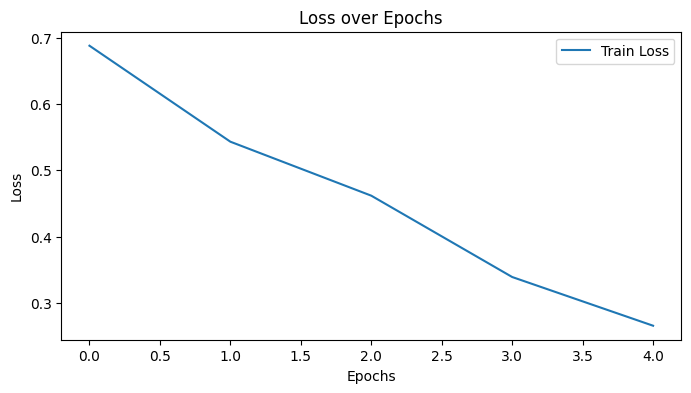

In [19]:
# Plotting the results

plt.figure(figsize=(8, 4))
plt.plot(results["train_loss"], label="Train Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Save and load the model

In [36]:
model_config_appendix = "_config.json"
model_file_appendix = "_model.pth"
def save_model(model, model_config, model_name):
    model_config_path = f"{model_name}{model_config_appendix}"
    with open(model_config_path, "w") as f:
        json.dump(model_config, f)

    model_params_path = f"{model_name}{model_file_appendix}"
    torch.save(model.state_dict(), model_params_path)
    
def load_model(model_name):
    with open(f'{model_name}{model_config_appendix}', 'r') as f:
        model_config = json.load(f)
    model_config['img_size'] = tuple(model_config['img_size'])

    loaded_model = cct.CCT(
        img_size = model_config['img_size'],
        embedding_dim = model_config['embedding_dim'],
        n_conv_layers = model_config['n_conv_layers'],
        kernel_size = model_config['kernel_size'],
        stride = model_config['stride'],
        padding = model_config['padding'],
        pooling_kernel_size = model_config['pooling_kernel_size'],
        pooling_stride = model_config['pooling_stride'],
        pooling_padding = model_config['pooling_padding'],
        num_layers = model_config['num_layers'],
        num_heads = model_config['num_heads'],
        mlp_ratio = model_config['mlp_ratio'],
        num_classes = model_config['num_classes'],
        positional_embedding = model_config['positional_embedding']
    )

    loaded_model.load_state_dict(torch.load(f'{model_name}{model_file_appendix}', weights_only=True))
    return loaded_model

## save and load (optional)

In [37]:
model_name = "models/cct"
save_model(model, model_config, model_name)
loaded_model = load_model(model_name)

# Testing the model

In [39]:
test_loss, test_acc = test_step(model=model,
                                dataloader=test_loader,
                                loss_fn=loss_fn,
                                device=device)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8957


## Visualize predictions

In [40]:
def visualize_random_predictions(model, dataloader):
    class_names = ["Okay", "Defective"]
    model.eval()
    images, labels = next(iter(dataloader))
    indices = random.sample(range(len(images)), 9)
    selected_images = images[indices]
    selected_labels = labels[indices]
    predictions = model(selected_images).argmax(dim=1)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = selected_images[i].permute(1, 2, 0).numpy()
        true_label = selected_labels[i].item()
        pred_label = predictions[i].item()

        border_color = "green" if true_label == pred_label else "red"

        ax.imshow(img)
        ax.set_title(f"True class: {class_names[true_label]}\nModel prediction: {class_names[pred_label]}", color=border_color)
        ax.axis("off")
        for spine in ax.spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(4)

    plt.tight_layout()
    plt.show()


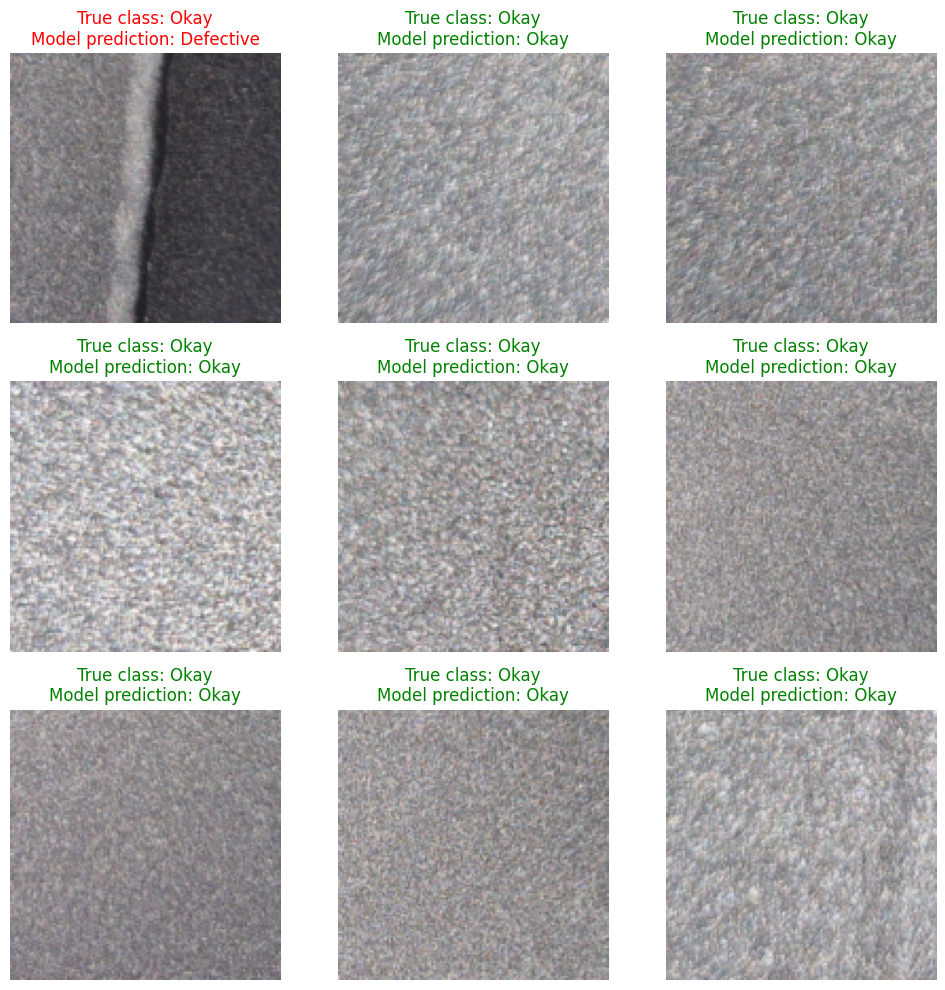

In [42]:
visualize_random_predictions(model, test_loader)

## Visualize heat-maps with Grad-CAM

In [48]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_image, target_spatial_position):
        output = self.model(input_image)

        x, y = target_spatial_position
        target_score = output[0, :, x, y].sum()

        self.model.zero_grad()
        target_score.backward(retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

        heatmap = torch.sum(weights * activations, dim=1).squeeze()

        heatmap = F.relu(heatmap)
        heatmap = - heatmap / torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

    def overlay_heatmap(self, heatmap, image, alpha=0.4, colormap=cv2.COLORMAP_JET):
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
        overlayed_image = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
        return overlayed_image


In [50]:
def get_features(model, x, target_layer):
    for layer in model.tokenizer.conv_layers:
        x = layer(x)
        if layer == target_layer:
            break
    return x

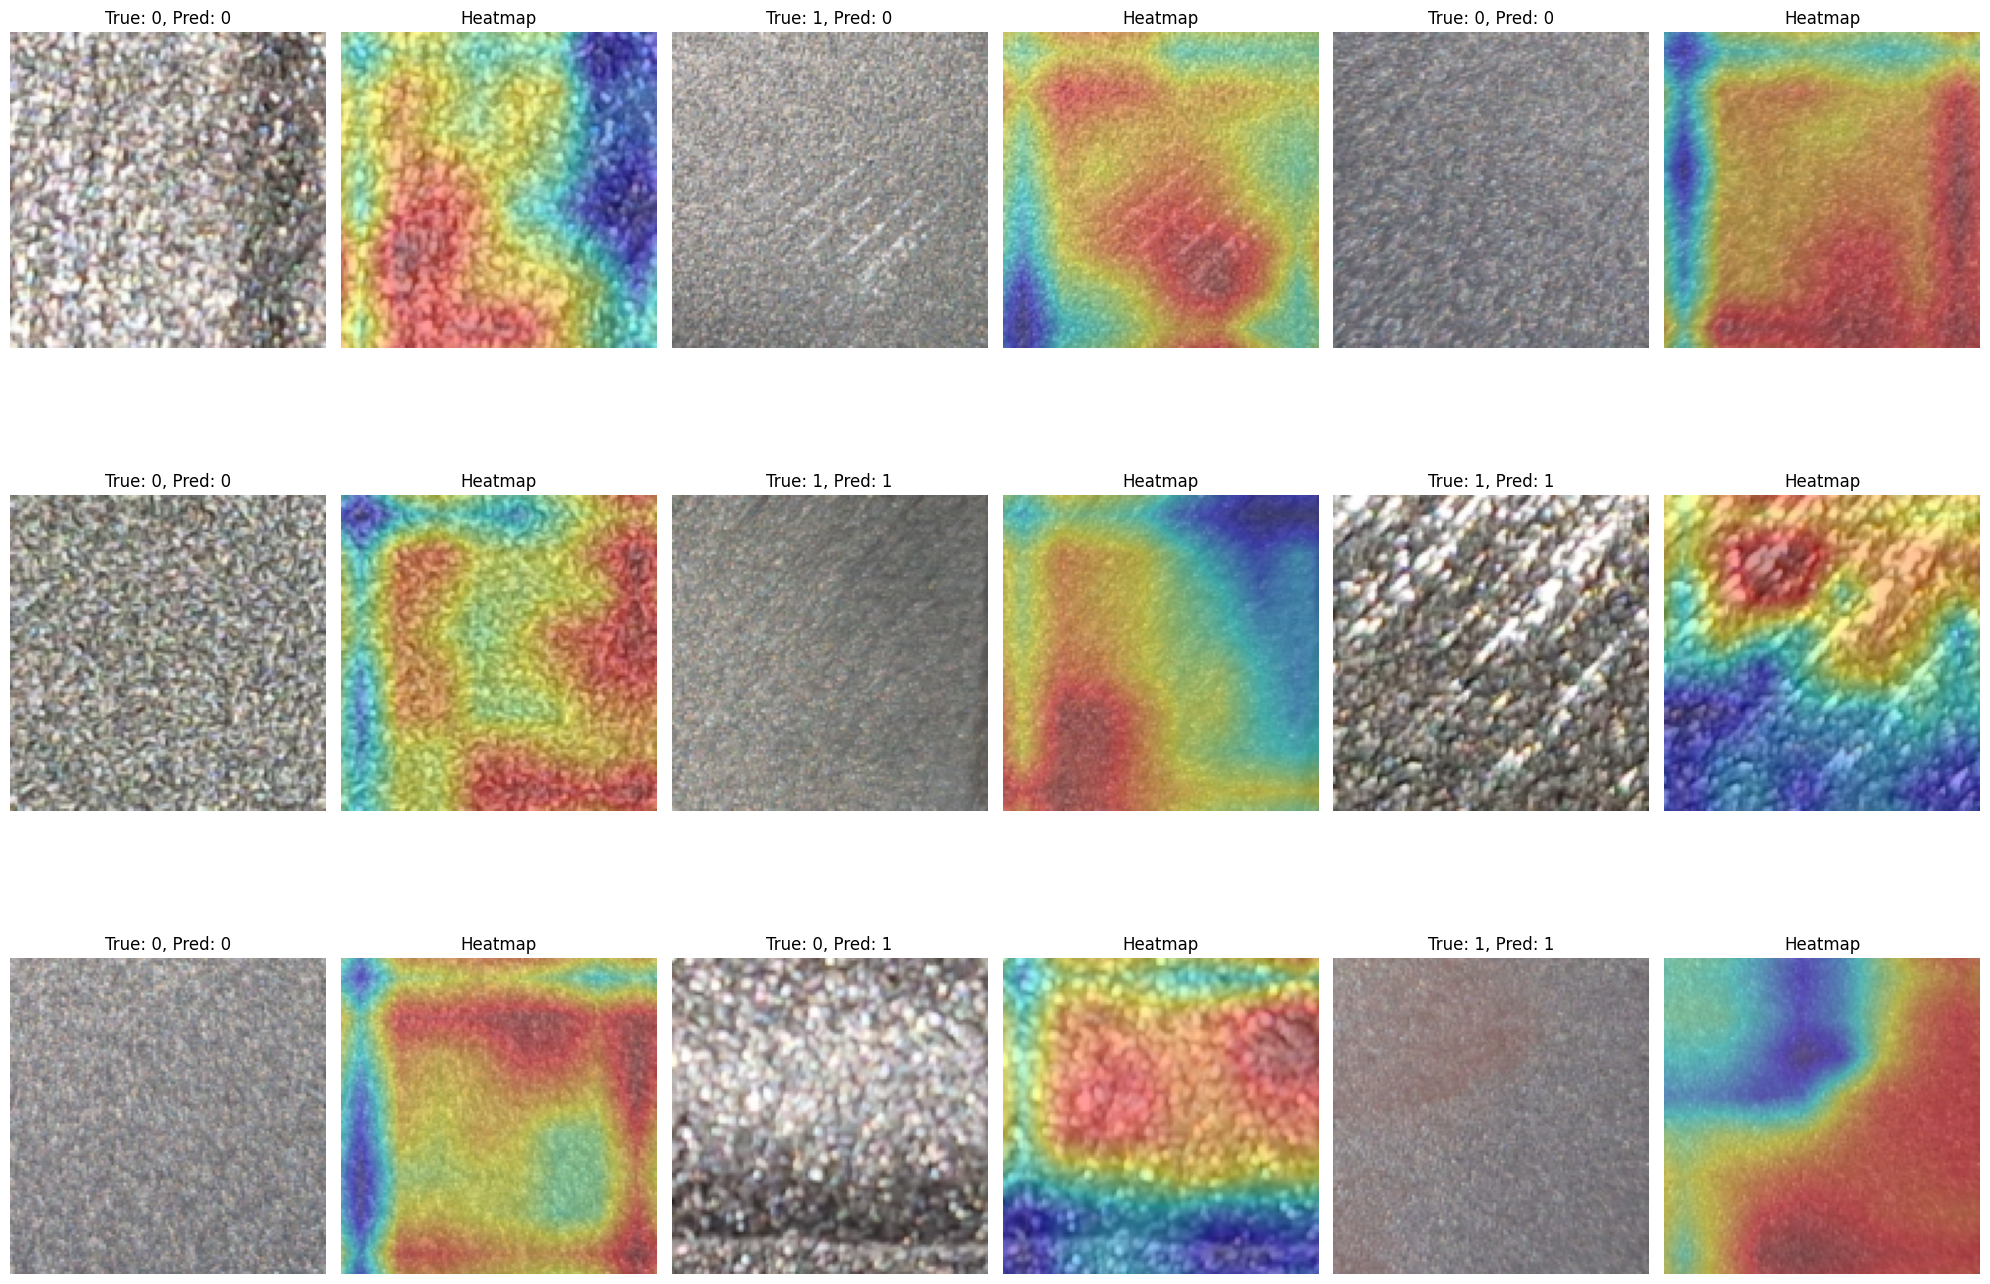

In [54]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size * 2, figsize=(20, 15))

random_indices = random.sample(range(len(test_dataset)), grid_size * grid_size)

grad_cam = GradCAM(model.tokenizer.conv_layers, target_layer=model.tokenizer.conv_layers[-1])

for idx, img_idx in enumerate(random_indices):
    image_tensor = test_dataset[img_idx][0].unsqueeze(0)
    target_class = test_dataset[img_idx][1]
    _, _, height, width = get_features(model, image_tensor, model.tokenizer.conv_layers[-1]).shape

    model.eval()
    with torch.no_grad():
        prediction = model(image_tensor).argmax(dim=1).item()

    combined_heatmap = np.zeros((height, width))

    for x in range(height):
        for y in range(width):
            heatmap = grad_cam.generate_heatmap(image_tensor, target_spatial_position=(x, y))
            combined_heatmap += heatmap

    combined_heatmap -= combined_heatmap.min()
    combined_heatmap /= combined_heatmap.max()

    input_image = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    input_image = (input_image * 255).astype(np.uint8)
    resized_heatmap = resize(combined_heatmap, input_image.shape[:2], mode='reflect')

    overlayed_image = grad_cam.overlay_heatmap(resized_heatmap, input_image)

    row = idx // grid_size
    col = idx % grid_size

    axes[row, col * 2].imshow(input_image)
    axes[row, col * 2].axis("off")
    axes[row, col * 2].set_title(f"True: {target_class}, Pred: {prediction}")

    axes[row, col * 2 + 1].imshow(overlayed_image)
    axes[row, col * 2 + 1].axis("off")
    axes[row, col * 2 + 1].set_title("Heatmap")

plt.tight_layout()
plt.show()
